In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline


### Importing the Dataset
We will be importing a popular open source dataset of [airlines tweets & their sentiment analysis](https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master).

Below are some initial visualizations of the dataset.

In [2]:
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

In [3]:
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Initial Analysis
Plot some details & stats about the dataset

In [4]:
# Set up matplotlib settings
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

6.0
4.0


<AxesSubplot:ylabel='airline'>

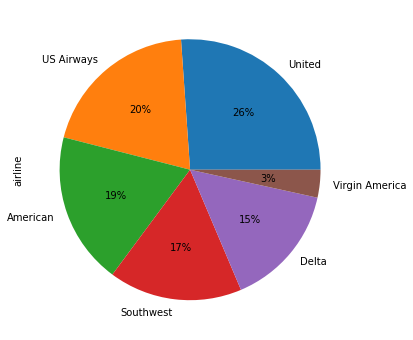

In [5]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [24]:
print(len(airline_tweets))
print(airline_tweets.shape)
print(type(airline_tweets.airline_sentiment.value_counts()))
airline_tweets.airline_sentiment.value_counts()

14640
(14640, 15)
<class 'pandas.core.series.Series'>


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:ylabel='airline_sentiment'>

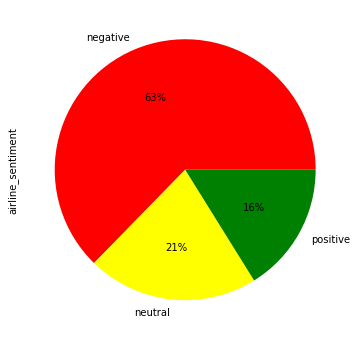

In [6]:

airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

### Clean the Data
Extract the tweets from the above dataframe and perform some basic parsing.

In [7]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values
print("labels sample ", labels[:5])

labels sample  ['neutral' 'positive' 'neutral' 'negative' 'negative']


In [8]:
def process_features(features):
    processed_features = []

    for sentence in range(0, len(features)):
        # Account for negative contractions
        #processed_feature = re.sub(r'(\w+)n\'t', '\g<1> not', str(features[sentence]))
        
        # Remove all the special characters
        processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

        # Remove all single characters
        processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

        # Remove single characters from the start
        processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

        # Substituting multiple spaces with single space
        processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

        # Removing prefixed 'b'
        processed_feature = re.sub(r'^b\s+', '', processed_feature)

        # Converting to Lowercase
        processed_feature = processed_feature.lower()

        processed_features.append(processed_feature)

    print(type(processed_features))
    processed_features = np.array(processed_features)
    print(processed_features.shape)
    print(processed_features[:10])
    return processed_features


processed_features = process_features(features)

<class 'list'>
(14640,)
[' virginamerica what dhepburn said '
 ' virginamerica plus you ve added commercials to the experience tacky '
 ' virginamerica didn today must mean need to take another trip '
 ' virginamerica it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse'
 ' virginamerica and it a really big bad thing about it'
 ' virginamerica seriously would pay 30 flight for seats that didn have this playing it really the only bad thing about flying va'
 ' virginamerica yes nearly every time fly vx this ear worm won go away '
 ' virginamerica really missed prime opportunity for men without hats parody there https co mwpg7grezp'
 ' virginamerica well didn but now do d'
 ' virginamerica it was amazing and arrived an hour early you re too good to me ']


### Vectorize the text
Here we use the TF-IDF method to parse the tweets into vectors of numbers.
- [TF-IDF](https://monkeylearn.com/blog/what-is-tf-idf/)
- [SciKitLearn TfIdfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [9]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

### Training the Model
Here we use the same airline tweet dataset above to train a model for tweet sentiment analysis.

In [10]:
from sklearn.model_selection import train_test_split

print('splitting into test set...')

# test_size .2 means we use 80% of the dataset to train the model
# and test it on the other 20%
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

splitting into test set...


In [11]:
from sklearn.ensemble import RandomForestClassifier

print('running randomForestClassifier')
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

running randomForestClassifier


RandomForestClassifier(n_estimators=200, random_state=0)

In [12]:
print(X_train.shape)
print(X_test.shape)
predictions = text_classifier.predict(X_test)

(11712, 2301)
(2928, 2301)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def printResults(y_test, predictions):
    print('confusion matrix\n')
    print(confusion_matrix(y_test,predictions))
    
    print('\nclassification report')
    print(classification_report(y_test,predictions))
    
    print('\naccuracy score')
    print(accuracy_score(y_test, predictions))
    
printResults(y_test, predictions)

confusion matrix

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]

classification report
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928


accuracy score
0.7599043715846995


### Todos
1. Move all logic into functions so we can test passing in our own data
1. Improve docs
1. Multithread training?

### Importing the Tweets to test
Here we use the Twitter package to get sample tweets

In [14]:
from trader import Twitter
import os

bearer=os.environ.get('BEARER_TOKEN')
twitter = Twitter(bearer=bearer)

query = "GME"
maximum = 100

response = twitter.search_tweets(query, maximum).json()['data']
print(len(response))

100


In [15]:
vectorized_tweets = np.vectorize(lambda obj: obj['text'])
tweets = vectorized_tweets(np.array(response))

print('len tweets: ', tweets[:5])
# Parse the tweets to remove extra characters
processed_features = process_features(tweets)
print(len(processed_features))


feature_names = vectorizer.get_feature_names()

# Vectorize the parsed tweets
stock_vectorizer = TfidfVectorizer(max_features=2500, min_df=.05, max_df=0.9, vocabulary=feature_names, stop_words=stopwords.words('english'))
processed_features = stock_vectorizer.fit_transform(processed_features).toarray()
print(processed_features.shape)

predictions = text_classifier.predict(processed_features)

len tweets:  ["RT @DiMartinoBooth: “While the 'value shorts' that were in GME earlier have been squeezed, most of the borrowed shares that were returned o…"
 'RT @doedeclare: FUCK THIS IM OUT\n\nI SAW WSB SAY THAT DOGE WAS BETTER THAN GME AND GOING TO $1. I SPENT MY WHOLE PAYCHECK AND IT WENT DOWN 8…'
 'RT @doedeclare: FUCK THIS IM OUT\n\nI SAW WSB SAY THAT DOGE WAS BETTER THAN GME AND GOING TO $1. I SPENT MY WHOLE PAYCHECK AND IT WENT DOWN 8…'
 'RT @InvestorTrip: Why does holding $GME $AMC increase the share price?\n\nSupply and demand. Hedge funds must close their short positions by…'
 'RT @WSBToken: #wallstreetbets @WSB Token is now LIVE on #TRON\n\nTRADE BELOW - \n\nhttps://t.co/ky85NfvHqH\n\nMarket runs 24/7, no trading halts,…']
<class 'list'>
(100,)
['rt dimartinobooth while the value shorts that were in gme earlier have been squeezed most of the borrowed shares that were returned '
 'rt doedeclare fuck this im out saw wsb say that doge was better than gme and going to 1 spent m

In [16]:
print(tweets.shape)
print(predictions.shape)

(100,)
(100,)


In [18]:
tweets = tweets.reshape((100,1))
predictions = predictions.reshape((100, 1))
print(tweets.shape)
print(predictions.shape)

total = np.concatenate((tweets, predictions), axis=1)
print(total.shape)

print(total)


(100, 1)
(100, 1)
(100, 2)
[["RT @DiMartinoBooth: “While the 'value shorts' that were in GME earlier have been squeezed, most of the borrowed shares that were returned o…"
  'negative']
 ['RT @doedeclare: FUCK THIS IM OUT\n\nI SAW WSB SAY THAT DOGE WAS BETTER THAN GME AND GOING TO $1. I SPENT MY WHOLE PAYCHECK AND IT WENT DOWN 8…'
  'negative']
 ['RT @doedeclare: FUCK THIS IM OUT\n\nI SAW WSB SAY THAT DOGE WAS BETTER THAN GME AND GOING TO $1. I SPENT MY WHOLE PAYCHECK AND IT WENT DOWN 8…'
  'negative']
 ['RT @InvestorTrip: Why does holding $GME $AMC increase the share price?\n\nSupply and demand. Hedge funds must close their short positions by…'
  'negative']
 ['RT @WSBToken: #wallstreetbets @WSB Token is now LIVE on #TRON\n\nTRADE BELOW - \n\nhttps://t.co/ky85NfvHqH\n\nMarket runs 24/7, no trading halts,…'
  'neutral']
 ['Don\'t let GME take all the attention, STONKS outside the small caps where moving too! Tune in to "This Week in Stocks" with @TraderNickyBAT. https://t.co/HO3qnn07vz

<AxesSubplot:ylabel='None'>

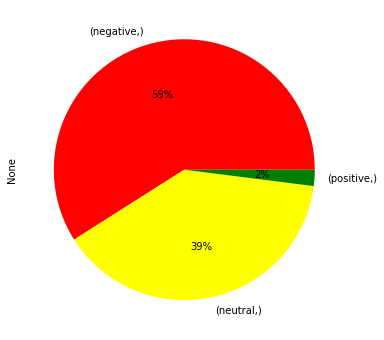

In [27]:
predictions_df = pd.DataFrame(predictions)
predictions_df.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])